In [1]:
# Preparations
import os
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from itertools import compress

import scipy
from scipy.ndimage import maximum_filter
from scipy.ndimage import map_coordinates
from scipy.ndimage import convolve1d as conv1
from scipy.ndimage import convolve as conv2

from skimage.transform import resize, rotate, SimilarityTransform
from skimage.io import imread
from skimage.measure import ransac

from pyflann import *
from utils import kdtreequery, matchWords, plotMatches, geometricVerification, getHistogramFromDescriptor, plotRetrievedImages, findNeighbours, plotFrameBoth

import time

# Select data directory
if os.path.isdir('/coursedata'):
    # JupyterHub
    course_data_dir = '/coursedata'
elif os.path.isdir('../../../coursedata'):
    # Local installation
    course_data_dir = '../../../coursedata'
else:
    # Docker
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-07-data')
print('Data stored in %s' % data_dir)

The data directory is /coursedata
Data stored in /coursedata/exercise-07-data


In [ ]:
# Description:
#    Exercise7 VGG practical notebook (Part2, fast track).
#
# This software is inspired by original object instance recognition
# VGG practical. 
# Licence; please refer to the file 
# Licence.txt, included with the software, for details.

# CS-E4850 Computer Vision Exercise Round 7
This is a minimal python version of Oxford Visual Geometry Group's Matlab practical on recognition of object instances (see the original webpage <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#part3>here</a>). By "minimal" it is meant that it uses pre-computed SIFT features and some other needed resources. All of them are calculated using the freely available matlab scripts found in the practical's github <a href=https://github.com/vedaldi/practical-object-instance-recognition >repository</a>. The practical is largely based on the vlfeat library (cf. http://www.vlfeat.org/) which unfortunately does not have a Python interface. 
<br><br>
This notebook is <b>the second part (PART II)</b> of the practical on the so-called <em>fast-track</em> and demonstrates the operation of <b>affine co-variant detectors</b>.
<br><br>
Go through the notebook and answer the questions. You can write your answers to a separate text document and submit that as you are not supposed to implement anything in this exercise.

## Part II: Affine co-variant detectors
So far the change in viewpoint between images has been a similarity transformation. Now we consider more severe viewpoint changes - for example where an object is fronto-parallel in one view, and turns away from the camera in the other as in the graffiti wall images below:


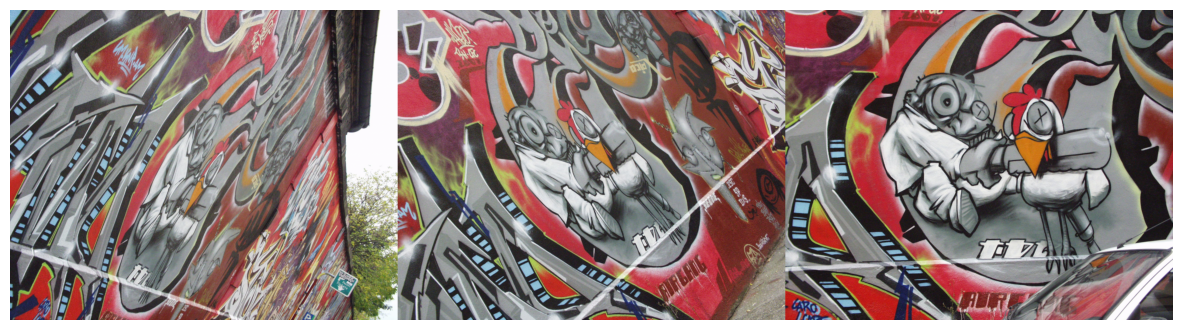

In [2]:
im1 = imread(data_dir+'/data/graf/img1.png') / 255.
im4 = imread(data_dir+'/data/graf/img4.png') / 255.
im6 = imread(data_dir+'/data/graf/img6.png') / 255.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
ax.imshow(np.hstack((im6, im4, im1)))
ax.axis('off')
plt.show()

In this case, there is foreshortening (anisotropic scaling) and perspective distortions between the images (as well as in-plane rotation, translation and scaling). A circle in one image cannot cover the same scene area as a circle in the other, but an ellipse can. Affine co-variant detectors are designed to find such regions.

In the following we will compare the number of matches using a similarity and affine co-variant detector as the viewpoint becomes progressively more extreme. The detectors are SIFT (for similarity) and SIFT+affine adaptation (for affine), while the descriptor are in both cases SIFT.

Task: Examine and run the python code lines below.

Note the behaviour in the number of verified matches as the viewpoint becomes more extreme. Observe that the matches also identify the regions of the images that are in common.

<b>Question</b>: The transformation between the images induced by the plane is a planar homography. The detections are only affine co-variant (not as general as a planar homography). So how can descriptors computed on these detections possibly match?

The descriptors computed on affine co-variant detections can match because SIFT descriptors are designed to be invariant to various geometric transformations, including rotation, scaling, and translation. Affine transformations, as a subclass of planar homographies, introduce more complex changes such as anisotropic scaling and shearing, but the SIFT descriptor can still capture local features in a way that remains consistent across such transformations.

Although affine transformations distort the image in more extreme ways than similarity transformations, the SIFT descriptor operates on the gradient of pixel intensities, which are not significantly altered by affine transformations. This allows the descriptor to maintain sufficient consistency for matching across images. Essentially, the affine co-variant detector adjusts the region of interest so that the features in both images, despite perspective or distortion, are normalized into a comparable form, allowing for accurate feature matching.

In [3]:
## -------------------------------------------------------------------
#      Preparations
# --------------------------------------------------------------------

# choose which images to use in the evaluation
imgPaths = [data_dir+'/data/graf/img1.png', \
            data_dir+'/data/graf/img2.png', \
            data_dir+'/data/graf/img3.png', \
            data_dir+'/data/graf/img4.png', \
            data_dir+'/data/graf/img5.png', \
            data_dir+'/data/graf/img6.png'] 

In [4]:
def getFeatures(imid, ftype):
    data = np.load(data_dir+'/data_part2/img{}_sift_{}_kps_descrs.npy'.format(imid,ftype), encoding='latin1', allow_pickle=True)
    kps = data.item().get('keypoints')
    descrs = data.item().get('descriptors')
    kps = kps.T
    descrs = descrs.T
    return kps, descrs

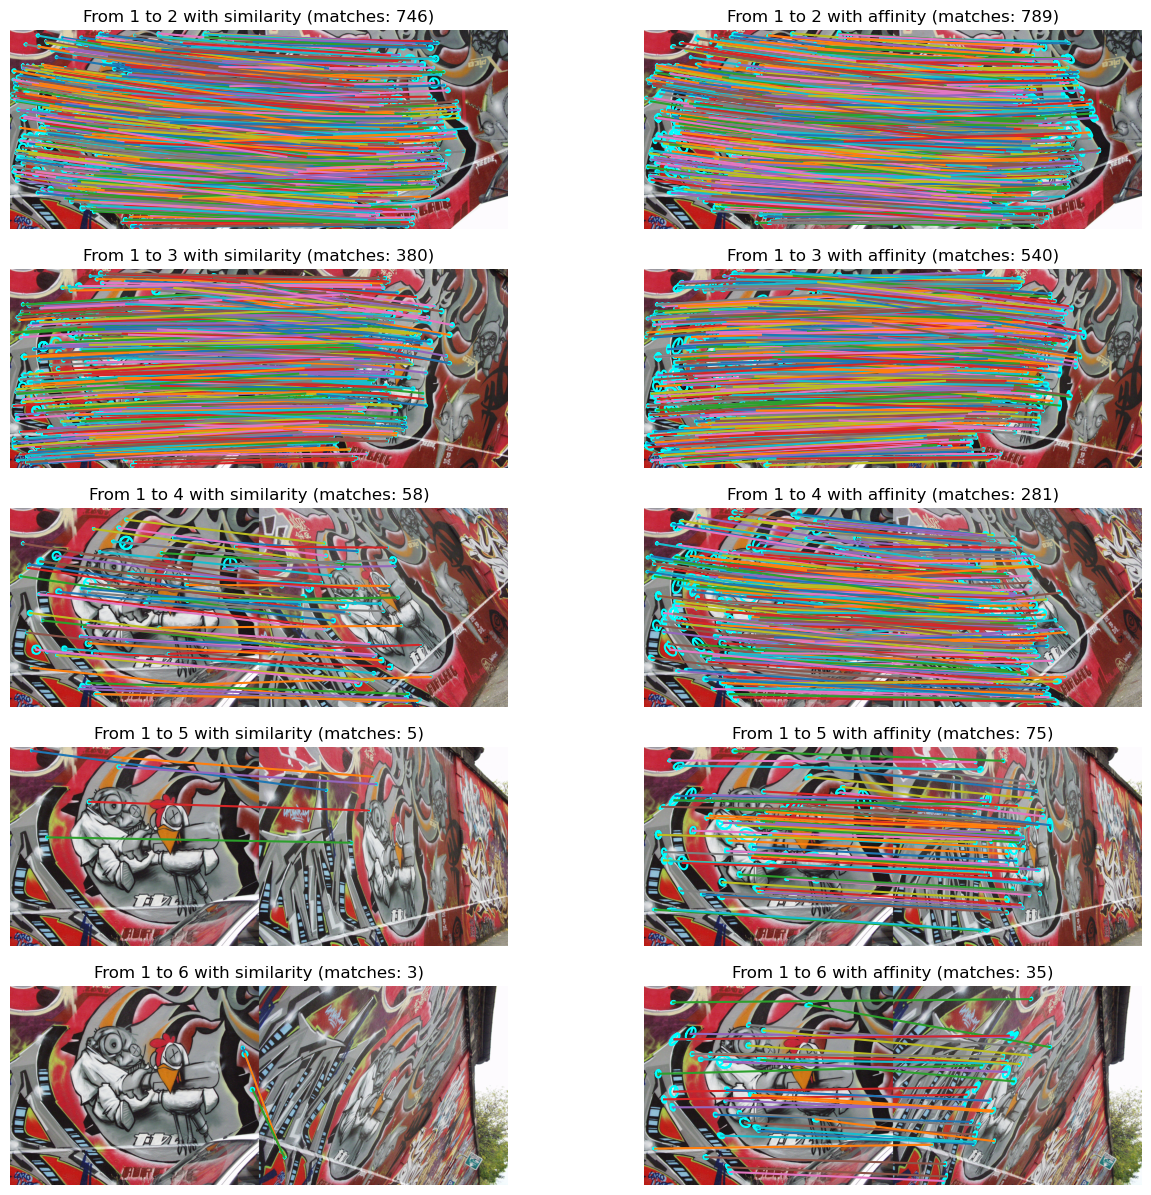

In [5]:
file_identifier = '1'
ii = [i for i, s in enumerate(imgPaths) if file_identifier in s]
ii = ii[0]

imgPaths2 = [s for i, s in enumerate(imgPaths) if file_identifier  not in s]

ftype=['disc', 'ellipse']

numInliers = np.zeros((5,2))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
ax = axes.ravel(order='F')
htype = ['similarity','affinity']
for i in range(2):
    im1 = imread(imgPaths[ii]) / 255.

    kps1, descrs1 = getFeatures(file_identifier, ftype[i])
    
    for iii, imPath in enumerate(imgPaths2):
        im2 = imread(imPath) / 255.
        fid = imPath.rstrip(".png")
        fid = fid.lstrip(data_dir+"/data/graf/img")
        
        kps2, descrs2 = getFeatures(fid, ftype[i])

        # Perform matching
        ind, dist = findNeighbours(descrs1, descrs2, 2)
        
        # Second nearest neighbour pre-filtering
        nnThreshold = 0.80
        ratio2 = np.divide(dist[:,0], dist[:,1])
        ok = ratio2 <= nnThreshold ** 2
        matches_raw = np.vstack((np.nonzero(ok), ind[ok, 0]))
        matches_raw = matches_raw.T
        
        # Geometric verification
        inliers_raw, H_raw = geometricVerification(kps1, kps2, matches_raw, 6)
        matches_geom = matches_raw[inliers_raw,:]
        
        # Count the number of inliers
        numInliers[iii,i] = matches_geom.shape[0]

        # Visualize
        ax[i*5+iii].set_title("From 1 to {} with {} (matches: {})".format(iii+2, htype[i], int(matches_geom.shape[0])))
        plotFrameBoth(ax[i*5+iii], im1, im2, kps1, kps2, matches_geom, plotMatches=True)
        ax[i*5+iii].axis("off")

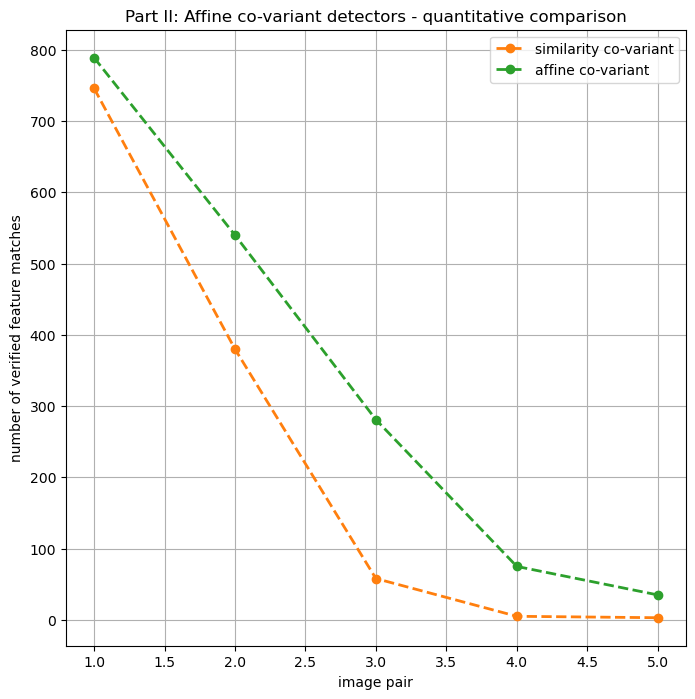

In [6]:
# Quantitative evaluation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = np.arange(1,6)
ax.plot(x, numInliers[:,0], color = 'C1', linewidth=2, linestyle='--', marker='o')
ax.plot(x, numInliers[:,1], color = 'C2', linewidth=2, linestyle='--', marker='o')
plt.title("Part II: Affine co-variant detectors - quantitative comparison")
plt.xlabel('image pair')
plt.ylabel('number of verified feature matches')
plt.legend(('similarity co-variant', 'affine co-variant'))
plt.grid()
plt.show()